## Import dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.offline import iplot, plot
import plotly.express as px
from scipy.stats import norm, kurtosis
from scipy.signal import butter, lfilter, freqz
from scipy import signal
from sklearn.model_selection import train_test_split
from collections import Counter

import glob
import os

plt.rcParams["figure.figsize"] = 16,10


from processing_funcs import *

## Read data

In [3]:
df = read_all()

In [4]:
df.head()

,time,lat,lon,height,velocity,direction,h_accuracy,v_accuracy,id_gps,x_lin_acc,y_lin_acc,z_lin_acc,x_gyro,y_gyro,z_gyro,x_acc,y_acc,z_acc,label
14,0.14,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,-0.068991,0.116175,-0.231500,-0.010804,0.001345,-0.033967,0.010029,-0.066162,9.487570,0
15,0.15,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.119553,0.105636,-0.053966,0.001346,0.008800,-0.035701,-0.054936,-0.025597,9.624087,0
16,0.16,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.013766,-0.061842,-0.085847,-0.007075,0.005302,-0.027966,0.181722,-0.081730,9.736653,0
17,0.17,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.063374,0.128633,-0.271607,-0.007945,0.006663,-0.028829,0.057930,-0.128134,9.693692,0
18,0.18,47.696266,17.726061,118.34948,-1.0,-1.0,418.967358,418.967358,1,0.089934,0.096254,-0.355428,-0.004748,-0.002140,-0.035702,0.103884,-0.026944,9.488020,0


## Groupping Data

In order to see how many data points belongs to eachy gps datapoint, we can group the data regarding to the `id_gps` and the `label` column.

In [5]:
agg_df = df.groupby(["label","id_gps"]).count()
agg_df.head()

time  lat  lon  height  velocity  direction  h_accuracy  \
label id_gps                                                            
0     1        163  163  163     163       163        163         163   
      2        100  100  100     100       100        100         100   
      3        100  100  100     100       100        100         100   
      4        100  100  100     100       100        100         100   
      5        100  100  100     100       100        100         100   

              v_accuracy  x_lin_acc  y_lin_acc  z_lin_acc  x_gyro  y_gyro  \
label id_gps                                                                
0     1              163        163        163        163     163     163   
      2              100        100        100        100     100     100   
      3              100        100        100        100     100     100   
      4              100        100        100        100     100     100   
      5              100        100        100        100     100     100   

              z_gyro  x_acc  y_acc  z_acc  
label id_gps                               
0     1          163    163    163    163  
      2          100    100    100    100  
      3          100    100    100    100  
      4          100    100    100    100  
      5          100    100    100    100

### Representing the number of datapoints / gps data

We need to do some data transformation, to get the data in a form which can be plotted.

In [6]:
agg_df.reset_index(inplace=True)

In [7]:
agg_df = agg_df[["label","id_gps","time"]]

In [8]:
agg_df.columns = ["label","id_gps","count"]
agg_df.head()

,label,id_gps,count
0,0,1,163
1,0,2,100
2,0,3,100
3,0,4,100
4,0,5,100


Text(0, 0.5, 'Frequenzy')

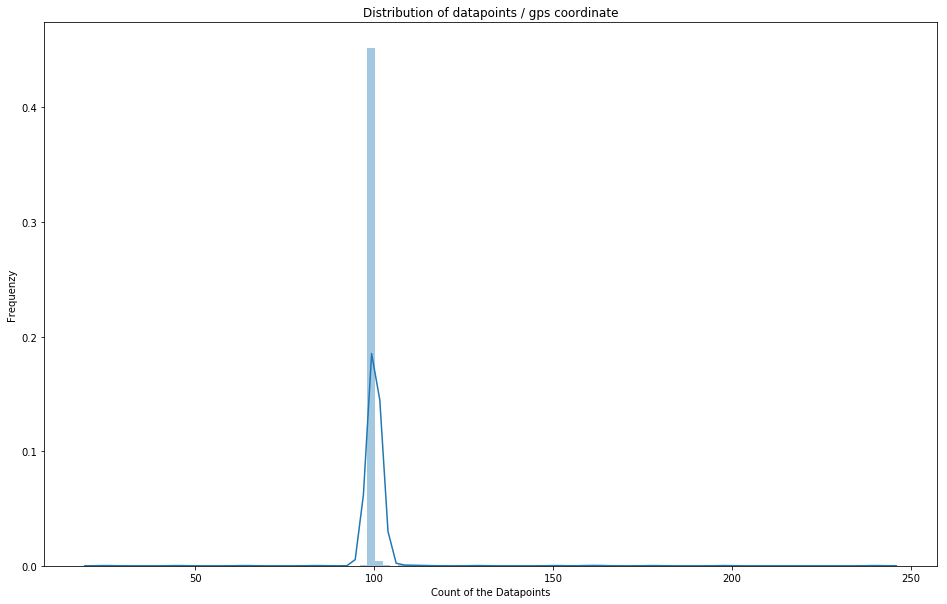

In [9]:
sns.distplot(agg_df["count"], 100)
plt.title("Distribution of datapoints / gps coordinate")
plt.xlabel("Count of the Datapoints")
plt.ylabel("Frequenzy")

The data point are equally distributed

### Prepare data

In [10]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


In [11]:
df.columns

Index(['time', 'lat', 'lon', 'height', 'velocity', 'direction', 'h_accuracy',
       'v_accuracy', 'id_gps', 'x_lin_acc', 'y_lin_acc', 'z_lin_acc', 'x_gyro',
       'y_gyro', 'z_gyro', 'x_acc', 'y_acc', 'z_acc', 'label'],
      dtype='object')

In [12]:
def filter_acc(df, cutoff=10, fs=50, order=2):

    signals = [ 'x_lin_acc', 'y_lin_acc', 'x_acc', 'y_acc', 'z_acc',]

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        experiment_df = df[df.experiment == experiment]

        list_signals = []

        for j in signals:

            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

In [13]:
def filter_gyro(df, cutoff=10, fs=50, order=2):

    signals = ['x_gyro', 'y_gyro', 'z_gyro']

    new_df = pd.DataFrame(columns=signals)

    for label in df.label.unique():

        experiment_df = df[df.experiment == experiment]

        list_signals = []

        for j in signals:

            filtered_signal = butter_lowpass_filter(experiment_df[j], cutoff=cutoff, fs=fs, order=order)

            list_signals.append(filtered_signal)

        new_df = pd.concat([new_df, pd.DataFrame(np.array(list_signals).T,columns=signals)])

    return new_df

In [14]:
def kurtosis_time(x):

    return kurtosis(x, fisher=True)

def rms_100(x):

    return np.sqrt(np.mean(x**2))

def crest(x):

    return max(abs(x))/np.sqrt(np.mean(x**2))

def create_aggregated(df):
    """Create a aggregated dataframe in time domain"""
    signals = ['x_lin_acc', 'y_lin_acc', 
               'x_acc', 'y_acc', 'z_acc',
               'x_gyro', 'y_gyro', 'z_gyro']

    agg_df = df.groupby(["label", "id_gps"]).agg({x: ["sum", "mean", "mad",
                                                "median", "min", "max",
                                                "std", "var", "sem",
                                                "skew", "quantile",
                                                kurtosis_time, rms_100,
                                                crest] for x in signals})

    return agg_df

In [15]:
feature_df = create_aggregated(df).reset_index()

In [16]:
feature_df.head()

label id_gps  x_lin_acc                                                    \
                      sum      mean       mad    median       min       max   
0     0      1 -22.207030 -0.136239  0.117869 -0.137389 -0.481967  0.149903   
1     0      2  -3.261845 -0.032618  0.082002 -0.032327 -0.320140  0.241167   
2     0      3  -4.234298 -0.042343  0.082078 -0.046981 -0.316525  0.228163   
3     0      4  19.420845  0.194208  0.130586  0.198483 -0.168488  0.568984   
4     0      5   2.818655  0.028187  0.076053  0.032478 -0.301072  0.221116   

                       ...    z_gyro                                          \
        std       var  ...       min       max       std       var       sem   
0  0.141934  0.020145  ... -0.038407  0.019060  0.020960  0.000439  0.001642   
1  0.104998  0.011024  ...  0.004437  0.026998  0.004069  0.000017  0.000407   
2  0.104113  0.010840  ...  0.005714  0.026547  0.004525  0.000020  0.000452   
3  0.163440  0.026712  ... -0.026722  0.029607  0.012857  0.000165  0.001286   
4  0.095146  0.009053  ... -0.021767 -0.002582  0.003297  0.000011  0.000330   

                                                         
       skew  quantile kurtosis_time   rms_100     crest  
0 -0.245129  0.004298     -1.747767  0.021991  1.746537  
1  0.358179  0.014297      0.330516  0.015283  1.766488  
2  0.100271  0.015716     -0.303948  0.016737  1.586147  
3  1.935585 -0.019049      2.478354  0.018980  1.559952  
4  0.002201 -0.012527      0.552075  0.013161  1.653923  

[5 rows x 114 columns]

## Shuffle Data

In [17]:
from sklearn.model_selection import train_test_split

In [19]:
X = feature_df.drop(["id_gps","label"], axis=1)
y = feature_df["label"]

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [26]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.2, 
                                                  random_state=42,
                                                  shuffle = True)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_train, 
                                                    y_train, 
                                                    test_size=0.2, 
                                                    random_state=42,
                                                    shuffle =  True)

In [29]:
print("X_train: ", X_train.shape)
print("X_val: ", X_val.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_val: ", y_val.shape)
print("y_test: ", y_test.shape)

X_train:  (604, 112)
X_val:  (189, 112)
X_test:  (152, 112)
y_train:  (604,)
y_val:  (189,)
y_test:  (152,)


Checking the number of the labels in the train, validation and test datasets.

In [35]:
print("Number of label for each label in the train dataset: {}".format(Counter(y_train).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_val).most_common()))
print("Number of label for each label in the validation dataset: {}".format(Counter(y_test).most_common()))

Number of label for each label in the train dataset: [(0, 399), (1, 126), (2, 79)]
Number of label for each label in the validation dataset: [(0, 131), (1, 30), (2, 28)]
Number of label for each label in the validation dataset: [(0, 101), (1, 30), (2, 21)]


## Normalize data

In [37]:
from sklearn.preprocessing import StandardScaler

In [38]:
scaler = StandardScaler()
scaled_train = scaler.fit_transform(X_train)
scaled_val = scaler.fit_transform(X_train)
scaled_test = scaler.fit_transform(X_train)

##  Prepare for ML

In [52]:
feature_df.columns

MultiIndex([(    'label',              ''),
            (   'id_gps',              ''),
            ('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=114)

In [54]:
feature_df.drop(["label", "id_gps"], axis=1).columns

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



MultiIndex([('x_lin_acc',           'sum'),
            ('x_lin_acc',          'mean'),
            ('x_lin_acc',           'mad'),
            ('x_lin_acc',        'median'),
            ('x_lin_acc',           'min'),
            ('x_lin_acc',           'max'),
            ('x_lin_acc',           'std'),
            ('x_lin_acc',           'var'),
            ('x_lin_acc',           'sem'),
            ('x_lin_acc',          'skew'),
            ...
            (   'z_gyro',           'min'),
            (   'z_gyro',           'max'),
            (   'z_gyro',           'std'),
            (   'z_gyro',           'var'),
            (   'z_gyro',           'sem'),
            (   'z_gyro',          'skew'),
            (   'z_gyro',      'quantile'),
            (   'z_gyro', 'kurtosis_time'),
            (   'z_gyro',       'rms_100'),
            (   'z_gyro',         'crest')],
           length=112)

In [61]:
if not os.path.exists("../data/train_test_val"):
        os.makedirs("../data/train_test_val")

cols = feature_df.drop(["label", "id_gps"], axis=1).columns
        
pd.DataFrame(scaled_train, columns=cols).to_csv( "../data/train_test_val/X_train.csv")
pd.DataFrame(scaled_val, columns=cols).to_csv("../data/train_test_val/X_val.csv")
pd.DataFrame(scaled_test, columns=cols).to_csv("../data/train_test_val/X_test.csv")
        
pd.DataFrame(y_train).to_csv( "../data/train_test_val/y_train.csv")
pd.DataFrame(y_val).to_csv("../data/train_test_val/y_val.csv")
pd.DataFrame(y_test).to_csv("../data/train_test_val/y_test.csv")

c:\users\mesza\.virtualenvs\road-surface-quality-7nv9hwjf\lib\site-packages\pandas\core\generic.py:3878: PerformanceWarning:

dropping on a non-lexsorted multi-index without a level parameter may impact performance.



In [63]:
pd.read_csv("../data/train_test_val/X_test.csv", header=[0,1], index_col=0)

x_lin_acc                                                              \
          sum      mean       mad    median       min       max       std   
0   -0.014538 -0.013235 -0.705619 -0.008868  0.434807 -0.465235 -0.727552   
1    0.071282  0.072720 -0.514274  0.075070  0.372955 -0.259910 -0.524743   
2    0.671259  0.673643  0.656267  0.555376  0.678975  0.713630  0.571018   
3   -0.304103 -0.303257 -0.168019 -0.311475  0.019010 -0.395595 -0.229572   
4    0.053052  0.054462 -0.546484  0.035015  0.407320 -0.308491 -0.579673   
..        ...       ...       ...       ...       ...       ...       ...   
599  0.015838  0.017188 -0.642177  0.021588  0.441744 -0.389084 -0.673628   
600  0.007708  0.009046 -0.627678  0.019359  0.445614 -0.336905 -0.642941   
601 -0.135117 -0.134004 -0.498942 -0.132157  0.137958 -0.387839 -0.504916   
602  0.032634  0.034011 -0.476817  0.039389  0.353953 -0.328808 -0.514618   
603  0.007749  0.009087 -0.226413  0.047698  0.107556 -0.137464 -0.258224   

                                   ...    z_gyro                      \
          var       sem      skew  ...       min       max       std   
0   -0.348563 -0.726427 -0.161410  ...  0.230868 -0.146753 -0.503713   
1   -0.317087 -0.523457  0.072287  ...  0.166811 -0.141936 -0.424762   
2    0.095637  0.573175  1.353648  ... -2.700224 -1.247025  2.347798   
3   -0.246210 -0.228051  0.770529  ... -0.101841 -0.311268 -0.254766   
4   -0.326998 -0.578431  0.445181  ... -0.135150 -0.380603 -0.238821   
..        ...       ...       ...  ...       ...       ...       ...   
599 -0.341563 -0.672460  0.062612  ...  0.254213 -0.158755 -0.546165   
600 -0.337137 -0.641749  0.293287  ...  0.229591 -0.132830 -0.496375   
601 -0.313257 -0.503614  0.570097  ...  0.734461  0.596994 -0.259975   
602 -0.315148 -0.513323 -0.451742  ...  0.217117 -0.112933 -0.435538   
603 -0.254392 -0.256726 -0.757787  ...  0.158686 -0.020086 -0.286258   

                                                                               
          var       sem      skew  quantile kurtosis_time   rms_100     crest  
0   -0.228641 -0.502621  0.533167  0.046469     -0.231479 -0.509428  0.482853  
1   -0.223841 -0.423465 -1.014913  0.034957      0.210924 -0.489700  1.241264  
2    1.234323  2.356317 -0.929433 -1.702114     -0.621031  1.664190 -0.756807  
3   -0.206604 -0.253025 -1.033845 -0.159708     -0.252577 -0.287336 -0.377839  
4   -0.204504 -0.237039  0.195777 -0.266243     -0.909727 -0.185144 -1.030635  
..        ...       ...       ...       ...           ...       ...       ...  
599 -0.230381 -0.545184 -0.452769  0.054620      0.125309 -0.516832  0.762511  
600 -0.228281 -0.495264 -0.341235  0.056015      0.240164 -0.506661  0.829339  
601 -0.207272 -0.258248  0.042556  0.677056     -0.572094  0.173958 -1.352894  
602 -0.224616 -0.434268 -0.022989  0.055911     -0.333899 -0.492426  0.346682  
603 -0.210509 -0.284599  0.635875  0.062512      0.025607 -0.456722  0.652506  

[604 rows x 112 columns]